<a href="https://colab.research.google.com/github/15karena/NamedEntityRecognition/blob/main/NER_BILSTM_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install livelossplot

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt

import pandas as pd

import numpy as np

np.random.seed(0)

plt.style.use("ggplot")



import tensorflow as tf

print('Tensorflow version:', tf.__version__)

from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras import Model, Input

from tensorflow.keras.layers import LSTM, Embedding, Dense

from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model

from tensorflow.keras.layers import GRU, BatchNormalization

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from livelossplot.tf_keras import PlotLossesCallback

from tqdm import tqdm

from tensorflow import keras
import string

Tensorflow version: 2.17.1


In [ ]:
csv_file = '/content/sample_data/dataset_NER.csv'

df = pd.read_csv(csv_file)

df= df.fillna(method="ffill")

df

<ipython-input-4-eddaaf2d4bd7>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df= df.fillna(method="ffill")


,Sentence #,Word,POS,Tag;;
0,Sentence: 1,Ribuan,NNS,O;;
1,Sentence: 1,dari,IN,O;;
2,Sentence: 1,demonstran,NNS,O;;
3,Sentence: 1,memiliki,VBP,O;;
4,Sentence: 1,berbaris,VBN,O;;
...,...,...,...,...
34995,Sentence: 1570,dengan,IN,O;;
34996,Sentence: 1570,informasi,NN,O;;
34997,Sentence: 1570,tentang,IN,O;;
34998,Sentence: 1570,terkait nuklir,JJ,O;;


In [ ]:
df = df.rename(columns={'Sentence #': 'Sentence', 'Tag;;': 'Tag'})

In [ ]:
df['Tag'] = df['Tag'].str.replace(';;', '', regex=False)

In [ ]:
df

,Sentence,Word,POS,Tag
0,Sentence: 1,Ribuan,NNS,O
1,Sentence: 1,dari,IN,O
2,Sentence: 1,demonstran,NNS,O
3,Sentence: 1,memiliki,VBP,O
4,Sentence: 1,berbaris,VBN,O
...,...,...,...,...
34995,Sentence: 1570,dengan,IN,O
34996,Sentence: 1570,informasi,NN,O
34997,Sentence: 1570,tentang,IN,O
34998,Sentence: 1570,terkait nuklir,JJ,O


In [ ]:
print(df['Word'])

0                Ribuan
1                  dari
2            demonstran
3              memiliki
4              berbaris
              ...      
34995            dengan
34996         informasi
34997           tentang
34998    terkait nuklir
34999          kegiatan
Name: Word, Length: 35000, dtype: object


In [ ]:
df['Word'] = df['Word'].str.lower()
print(df['Word'])

0                ribuan
1                  dari
2            demonstran
3              memiliki
4              berbaris
              ...      
34995            dengan
34996         informasi
34997           tentang
34998    terkait nuklir
34999          kegiatan
Name: Word, Length: 35000, dtype: object


In [ ]:
words = list(set(df["Word"].values))

words.append("EOS")

num_words = len(words)

num_words


4576

In [ ]:
print(words)

['tampa', 'zurab', '900', 'turned', 'menyia-nyiakan', 'manuver', 'pemukiman', 'mulai', 'ketua komite', 'obral', 'pasport', 'uribe', 'melanggar hukum', 'hingga', 'penyebaran', 'minus', 'konservasi', 'keajaiban', 'kazakhstan', 'hamil', 'dibuat', 'diberikan', 'teralir', 'jersey', '130', 'jual', 'sukses', 'lumpuh', 'berhenti', 'gerbang', 'keputusan', 'kereta', 'strike', 'evakuasi', 'daw', 'singkat', 'matahari', 'tokar', 'limbah', 'dapat diperbarui', 'berpotensi', 'kakao', 'menderita', 'saud', '96', '1910', 'kelab malam', 'kamerun', 'perilaku', 'indissoluble', 'sistem', 'perahu', 'cuplikan', 'tanpa', 'joel', 'radio', 'pajekan', 'sensitif', 'tanda tangani', 'sudan', 'serangan balik', 'luis', 'steinmeier', 'swaziland', 'mayer', 'profiling', 'pengungsi', 'tentu', 'jointly', 'ibero-american', 'bolak-balik', 'ijin', 'kawat', 'kuba', 'korup', 'sebelum', 'case', 'pakistan', 'tak tersembuhkan', 'kunjungi', 'kunci', 'marinir', 'impunity', 'terpisah', 'koran', 'peineta', 'serangan udara', 'signifikan

In [ ]:
tags = list(set(df["Tag"].values))

num_tags = len(tags)

num_tags

17

In [ ]:
print(tags)

['I-nat', 'B-tim', 'B-org', 'B-nat', 'O', 'B-per', 'B-art', 'I-per', 'I-art', 'B-eve', 'I-tim', 'I-eve', 'I-gpe', 'I-org', 'B-geo', 'I-geo', 'B-gpe']


In [ ]:
word_dict = {word: idx for idx, word in enumerate(words)}

tag_dict = {tag : idx for idx, tag in enumerate(tags)}

In [ ]:
len(word_dict)

4576

In [ ]:
len(tag_dict)

17

In [ ]:
idx_to_word_dict = {idx: word for word, idx in word_dict.items()}

In [ ]:
idx_to_word_dict

{0: 'tampa',
 1: 'zurab',
 2: '900',
 3: 'turned',
 4: 'menyia-nyiakan',
 5: 'manuver',
 6: 'pemukiman',
 7: 'mulai',
 8: 'ketua komite',
 9: 'obral',
 10: 'pasport',
 11: 'uribe',
 12: 'melanggar hukum',
 13: 'hingga',
 14: 'penyebaran',
 15: 'minus',
 16: 'konservasi',
 17: 'keajaiban',
 18: 'kazakhstan',
 19: 'hamil',
 20: 'dibuat',
 21: 'diberikan',
 22: 'teralir',
 23: 'jersey',
 24: '130',
 25: 'jual',
 26: 'sukses',
 27: 'lumpuh',
 28: 'berhenti',
 29: 'gerbang',
 30: 'keputusan',
 31: 'kereta',
 32: 'strike',
 33: 'evakuasi',
 34: 'daw',
 35: 'singkat',
 36: 'matahari',
 37: 'tokar',
 38: 'limbah',
 39: 'dapat diperbarui',
 40: 'berpotensi',
 41: 'kakao',
 42: 'menderita',
 43: 'saud',
 44: '96',
 45: '1910',
 46: 'kelab malam',
 47: 'kamerun',
 48: 'perilaku',
 49: 'indissoluble',
 50: 'sistem',
 51: 'perahu',
 52: 'cuplikan',
 53: 'tanpa',
 54: 'joel',
 55: 'radio',
 56: 'pajekan',
 57: 'sensitif',
 58: 'tanda tangani',
 59: 'sudan',
 60: 'serangan balik',
 61: 'luis',
 62: '

In [ ]:
idx_to_tag_dict = {idx: tag for tag, idx in tag_dict.items()}

In [ ]:
idx_to_tag_dict

{0: 'I-nat',
 1: 'B-tim',
 2: 'B-org',
 3: 'B-nat',
 4: 'O',
 5: 'B-per',
 6: 'B-art',
 7: 'I-per',
 8: 'I-art',
 9: 'B-eve',
 10: 'I-tim',
 11: 'I-eve',
 12: 'I-gpe',
 13: 'I-org',
 14: 'B-geo',
 15: 'I-geo',
 16: 'B-gpe'}

In [ ]:
word_dict

{'tampa': 0,
 'zurab': 1,
 '900': 2,
 'turned': 3,
 'menyia-nyiakan': 4,
 'manuver': 5,
 'pemukiman': 6,
 'mulai': 7,
 'ketua komite': 8,
 'obral': 9,
 'pasport': 10,
 'uribe': 11,
 'melanggar hukum': 12,
 'hingga': 13,
 'penyebaran': 14,
 'minus': 15,
 'konservasi': 16,
 'keajaiban': 17,
 'kazakhstan': 18,
 'hamil': 19,
 'dibuat': 20,
 'diberikan': 21,
 'teralir': 22,
 'jersey': 23,
 '130': 24,
 'jual': 25,
 'sukses': 26,
 'lumpuh': 27,
 'berhenti': 28,
 'gerbang': 29,
 'keputusan': 30,
 'kereta': 31,
 'strike': 32,
 'evakuasi': 33,
 'daw': 34,
 'singkat': 35,
 'matahari': 36,
 'tokar': 37,
 'limbah': 38,
 'dapat diperbarui': 39,
 'berpotensi': 40,
 'kakao': 41,
 'menderita': 42,
 'saud': 43,
 '96': 44,
 '1910': 45,
 'kelab malam': 46,
 'kamerun': 47,
 'perilaku': 48,
 'indissoluble': 49,
 'sistem': 50,
 'perahu': 51,
 'cuplikan': 52,
 'tanpa': 53,
 'joel': 54,
 'radio': 55,
 'pajekan': 56,
 'sensitif': 57,
 'tanda tangani': 58,
 'sudan': 59,
 'serangan balik': 60,
 'luis': 61,
 'stei

In [ ]:
tag_dict

{'I-nat': 0,
 'B-tim': 1,
 'B-org': 2,
 'B-nat': 3,
 'O': 4,
 'B-per': 5,
 'B-art': 6,
 'I-per': 7,
 'I-art': 8,
 'B-eve': 9,
 'I-tim': 10,
 'I-eve': 11,
 'I-gpe': 12,
 'I-org': 13,
 'B-geo': 14,
 'I-geo': 15,
 'B-gpe': 16}

In [ ]:
class SentenceGetter(object):

    def __init__(self, data):

        self.n_sent = 1

        self.data = data

        self.empty = False

        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),

                                                           s["POS"].values.tolist(),

                                                           s["Tag"].values.tolist())]

        self.grouped = self.data.groupby("Sentence").apply(agg_func)

        self.sentences = [s for s in self.grouped]



    def get_next(self):

        try:

            s = self.grouped["Sentence: {}".format(self.n_sent)]

            self.n_sent += 1

            return s

        except:

            return None

In [ ]:
getter = SentenceGetter(df)

sentences = getter.sentences

<ipython-input-26-91a8e2a67db8>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  self.grouped = self.data.groupby("Sentence").apply(agg_func)


In [ ]:
sentences[0]

[('u.s.', 'NNP', 'B-geo'),
 ('tentang', 'IN', 'O'),
 ('apa', 'WP', 'O'),
 ('mereka', 'PRP', 'O'),
 ('saksi.', 'VBD', 'O'),
 ('.', '.', 'O')]

In [ ]:
import requests, zipfile, io

zip_file_url = "https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip"

r = requests.get(zip_file_url)

z = zipfile.ZipFile(io.BytesIO(r.content))

z.extractall()

In [ ]:
def load_fasttext_embeddings(file_path):

    embeddings = {}

    with open(file_path, 'r', encoding='utf-8') as f:

        for line in tqdm(f):

            values = line.rstrip().rsplit(' ')

            word = values[0]

            vector = np.asarray(values[1:], dtype='float32')

            embeddings[word] = vector

    print(f"Found {len(embeddings)} word vectors.")

    return embeddings

In [ ]:
file_path = 'wiki-news-300d-1M.vec'

fasttext_embeddding = load_fasttext_embeddings(file_path)

999995it [01:37, 10270.88it/s]

Found 999995 word vectors.


In [ ]:
def create_embedding_matrix(vocab, embeddings_index, embedding_dim):


    embedding_matrix = np.zeros((len(vocab), embedding_dim))


    for word, i in vocab.items():

        embedding_vector = embeddings_index.get(word)

        if embedding_vector is not None:

            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [ ]:
embedding = create_embedding_matrix(word_dict, fasttext_embeddding, embedding_dim=300)

In [ ]:
embedding.shape

(4576, 300)

In [ ]:
max_len = 50

X = [[word_dict[w[0]] for w in s] for s in sentences]

X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)



y = [[tag_dict[w[2]] for w in s] for s in sentences]

y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag_dict['O'])

In [ ]:
X

array([[2636, 4225, 3849, ..., 4575, 4575, 4575],
       [2476, 1925,  581, ...,  921,  310, 2988],
       [4240,  412, 1434, ..., 4575, 4575, 4575],
       ...,
       [3056,  478, 3909, ..., 4575, 4575, 4575],
       [4097,  464, 4032, ..., 4575, 4575, 4575],
       [1908,  464, 3754, ..., 4575, 4575, 4575]], dtype=int32)

In [ ]:
len(X)

1611

In [ ]:
y

array([[14,  4,  4, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 2, 13,  4, ...,  4,  4,  4],
       ...,
       [ 4,  4,  4, ...,  4,  4,  4],
       [ 4,  4, 16, ...,  4,  4,  4],
       [ 4,  4,  4, ...,  4,  4,  4]], dtype=int32)

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
X_train_val.shape, X_test.shape, y_train_val.shape, y_test.shape

((1449, 50), (162, 50), (1449, 50), (162, 50))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=42)

In [ ]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1304, 50), (145, 50), (1304, 50), (145, 50))

In [ ]:
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.optimizers import AdamW

In [ ]:
def build_model(word_dict, embedding, max_len=50, embedding_dim=300, num_tags=17):

    # Model input

    input_layer = Input(shape=(max_len,))



    # Embedding layer

    embeddings = Embedding(

        input_dim=len(word_dict),  # Jumlah kata unik

        output_dim=embedding_dim,  # Dimensi embedding (misalnya 300)

        weights=[embedding],       # Matriks embedding pre-trained

        input_length=max_len,      # Panjang input sequence

        #mask_zero=True,            # Masking untuk padding

        trainable=True,            # Embedding bisa dilatih ulang

        name='embedding_layer'

    )(input_layer)

    embedding_layer = SpatialDropout1D(0.2)(embeddings)

    cnn_layer = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(embedding_layer)



    # Bidirectional LSTM layers

    output_sequences = Bidirectional(LSTM(units=256, return_sequences=True, recurrent_dropout=0.2))(cnn_layer)

    output_sequences = Bidirectional(LSTM(units=256, return_sequences=True, recurrent_dropout=0.2))(output_sequences)



    # Dense layer for output

    dense_out = TimeDistributed(Dense(num_tags, activation='softmax'))(output_sequences)



    # Model definition

    model = Model(inputs=input_layer, outputs=dense_out)


    # Model compilation
    #optimizer = Adam(learning_rate=0.01)
    optimizer = AdamW(learning_rate=0.01, weight_decay=1e-4)
    #optimizer = RMSprop(learning_rate=0.01)
    #optimizer = SGD(learning_rate=0.001, momentum=0.9)

    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])



    return model


In [ ]:
model = build_model(word_dict, embedding, max_len=50, embedding_dim=300, num_tags=18)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_layer (Embedding)          │ (None, 50, 300)             │       1,372,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ (None, 50, 300)             │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 50, 128)             │         115,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 50, 512)             │         788,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 50, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 50, 18)              │           9,234 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,860,754 (14.73 MB)

 Trainable params: 3,860,754 (14.73 MB)

 Non-trainable params: 0 (0.00 B)

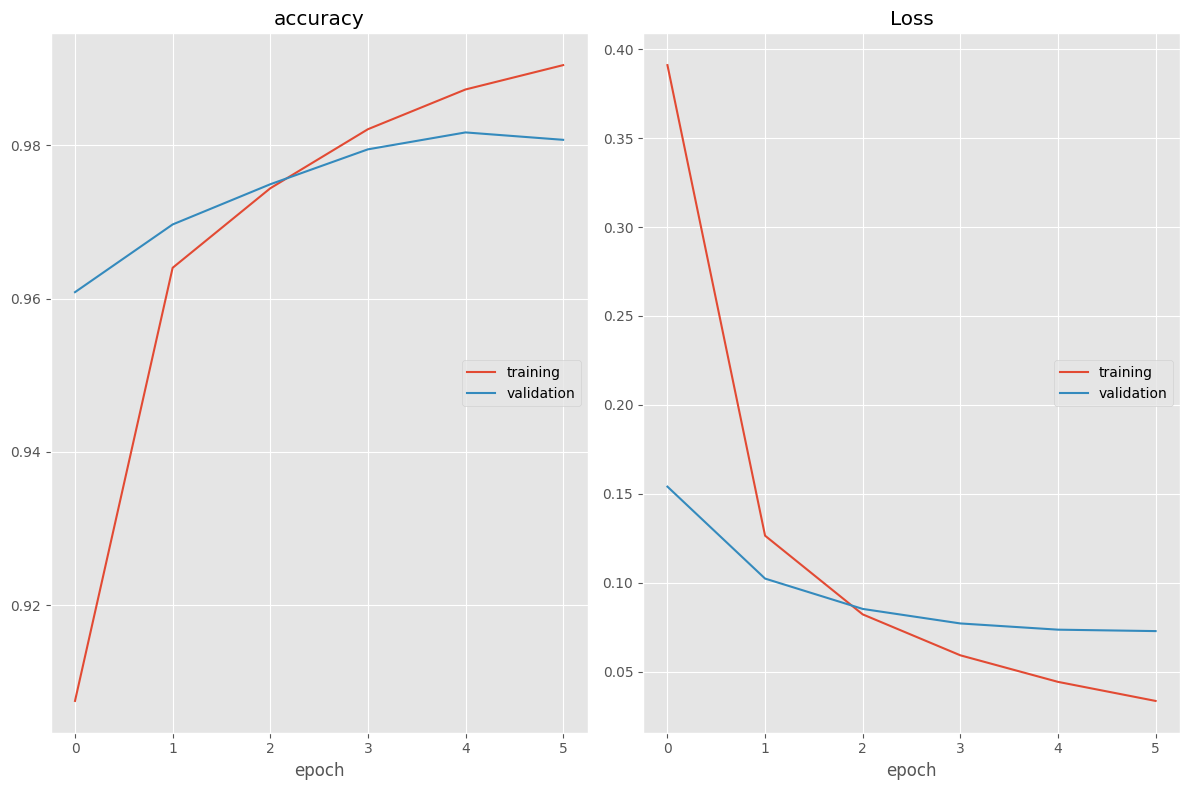

accuracy
	training         	 (min:    0.908, max:    0.990, cur:    0.990)
	validation       	 (min:    0.961, max:    0.982, cur:    0.981)
Loss
	training         	 (min:    0.034, max:    0.391, cur:    0.034)
	validation       	 (min:    0.073, max:    0.154, cur:    0.073)

Epoch 6: val_loss improved from 0.07368 to 0.07287, saving model to model_weights_percobaan_9.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.9907 - loss: 0.0324 - val_accuracy: 0.9807 - val_loss: 0.0729


In [ ]:
checkpoint = ModelCheckpoint("model_weights_percobaan_9.weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')



early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=1, verbose=0, mode='max', baseline=None, restore_best_weights=False)



callbacks = [PlotLossesCallback(), checkpoint, early_stopping]



history = model.fit(
    x=X_train,  # Training data
    y=y_train,  # Training labels
    validation_data=(X_val, y_val),  # Validation data
    batch_size=32,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

In [ ]:
model.evaluate(X_test, y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 407ms/step - accuracy: 0.9756 - loss: 0.1075


[0.10767444223165512, 0.9751851558685303]

# TESTING

In [ ]:
i = np.random.randint(0, X_test.shape[0])
p = model.predict(np.array([X_test[i]]))[0]
p = np.argmax(p, axis=-1)
print("{:15} {:15}: ({})".format("Word", "Predicted tag", "True tag"))
print("="*44)
for w, true, pred in zip(X_test[i], y_test[i], p):
    if w != num_words-1:
        word = idx_to_word_dict[w]
        print("{:15}:{:15} ({})".format(word, tags[pred], tags[true]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Word            Predicted tag  : (True tag)
a              :O               (O)
mantan         :O               (O)
putih          :B-org           (B-org)
rumah          :I-org           (I-org)
ajudan         :I-org           (O)
ke             :O               (O)
mantan         :O               (O)
u.s.           :B-gpe           (B-geo)
presiden       :B-per           (B-per)
george         :I-per           (I-per)
bush           :I-per           (I-per)
memiliki       :O               (O)
been           :O               (O)
dihukum        :O               (O)
ke             :O               (O)
30             :O               (O)
bulan          :O               (O)
dalam          :O               (O)
penjara        :O               (O)
untuk          :O               (O)
mencuri        :O               (O)
hampir         :O               (O)
$              :O               (O)


In [ ]:
i = np.random.randint(0, X_test.shape[0])
p = model.predict(np.array([X_test[i]]))[0]
p = np.argmax(p, axis=-1)
print("{:15} {:15}: ({})".format("Word", "Predicted tag", "True tag"))
print("="*44)
for w, true, pred in zip(X_test[i], y_test[i], p):
    if w != num_words-1:
        word = idx_to_word_dict[w]
        print("{:15}:{:15} ({})".format(word, tags[pred], tags[true]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Word            Predicted tag  : (True tag)
a              :O               (O)
moskwa         :B-gpe           (B-geo)
pengadilan     :O               (O)
memiliki       :O               (O)
ditolak        :O               (O)
yang           :O               (O)
banding        :O               (O)
dari           :O               (O)
mantan         :O               (O)
rusianame      :B-gpe           (B-gpe)
minyak         :O               (O)
taipan         :B-org           (O)
mikhail        :B-per           (B-per)
khodorkovsky   :I-per           (I-per)
melawan        :O               (O)
-nya           :O               (O)
keyakinan      :O               (O)
nyala          :O               (O)
penipuan       :O               (O)
dan            :O               (O)
pajak          :O               (O)
penghindaran   :O               (O)
biaya          :O               (O)


In [ ]:
i = np.random.randint(0, X_test.shape[0])
p = model.predict(np.array([X_test[i]]))[0]
p = np.argmax(p, axis=-1)
print("{:15} {:15}: ({})".format("Word", "Predicted tag", "True tag"))
print("="*44)
for w, true, pred in zip(X_test[i], y_test[i], p):
    if w != num_words-1:
        word = idx_to_word_dict[w]
        print("{:15}:{:15} ({})".format(word, tags[pred], tags[true]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Word            Predicted tag  : (True tag)
obama          :B-per           (B-per)
's             :O               (O)
pengumuman     :O               (O)
concides       :O               (O)
dengan         :O               (O)
a              :O               (O)
utama          :O               (O)
energi         :O               (O)
puncak         :O               (O)
dalam          :O               (O)
saudi          :B-geo           (B-geo)
arab           :I-geo           (I-geo)
nyala          :O               (O)
cara           :O               (O)
ke             :O               (O)
rein           :O               (O)
dalam          :O               (O)
yang           :O               (O)
tinggi         :B-org           (O)
minyak         :O               (O)
harga          :O               (O)
.              :O               (O)


In [ ]:
i = np.random.randint(0, X_test.shape[0])
p = model.predict(np.array([X_test[i]]))[0]
p = np.argmax(p, axis=-1)
print("{:15} {:15}: ({})".format("Word", "Predicted tag", "True tag"))
print("="*44)
for w, true, pred in zip(X_test[i], y_test[i], p):
    if w != num_words-1:
        word = idx_to_word_dict[w]
        print("{:15}:{:15} ({})".format(word, tags[pred], tags[true]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
Word            Predicted tag  : (True tag)
the            :O               (O)
kecelakaan     :O               (O)
terjadi        :O               (O)
satu           :O               (O)
siang          :O               (O)
sesudah        :O               (O)
a              :O               (O)
tembak!        :O               (O)
pada           :O               (O)
a              :O               (O)
batubara       :O               (O)
tambang        :O               (O)
dalam          :O               (O)
timur laut     :O               (O)
china          :B-geo           (B-geo)
dimatikan      :O               (O)
pada           :O               (O)
paling tidak   :O               (O)
lima           :O               (O)
penambang      :O               (O)
dan            :O               (O)
terjebak       :O               (O)
30             :O               (O)
.              :O               (O)
